In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Simplex'

The following is the mixture matrix A


<IPython.core.display.Math object>

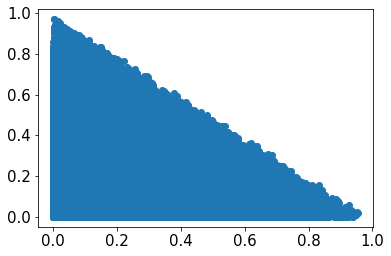

In [2]:
NumberofSources = 5
NumberofMixtures = 10
N = 500000
np.random.seed(0)
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)

SNR=30
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

# X, NoisePart = addWGN(X, SNR, return_noise = True)

# SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
# print("Input SNR is : {}".format(SNRinp))

plt.scatter(S[0,:], S[2,:])
plt.show()

In [3]:
def offdiag(A, return_diag = False):
    """_summary_

    Args:
        A (_type_): _description_
        return_diag (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if return_diag:
        diag = np.diag(A)
        return A - np.diag(diag), diag
    else:
        return A - np.diag(diag)


In [4]:
MUS = 0.25
gammaM_start = [MUS, MUS]
gammaM_stop = [1e-3, 1e-3]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-3, 1e-3]

OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.01,0.01]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

In [5]:
np.random.seed(100)
debug_iteration_point = 25000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gammaM_start = gammaM_start, gammaM_stop = gammaM_stop, 
                     gammaW_start = gammaW_start, gammaW_stop = gammaW_stop,
                     beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

In [6]:
hidden_layer_gain = 2
lr_rule = "divide_by_slow_loop_index"
neural_dynamic_iterations = 750
neural_lr_decay_multiplier = 0.005
neural_lr_start = 0.5
neural_lr_stop = 0.5
stlambd_lr = 0.01
OUTPUT_COMP_TOL = 1e-5

W_HX = model.W_HX
W_YH = model.W_YH
M_H = model.M_H
M_Y = model.M_Y
D1 = model.D1
D2 = model.D2

In [7]:
np.random.seed(100)
H = np.zeros((h_dim,samples))
Y = np.zeros((s_dim,samples))

H = np.random.randn(h_dim,samples)#*0.05
Y = np.random.randn(s_dim,samples)#*0.05

i_sample = 287

x_current  = X[:,i_sample] # Take one input
y = Y[:,i_sample]
h = H[:,i_sample]

In [8]:
model.run_neural_dynamics_simplex_jit(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
                                        neural_dynamic_iterations, neural_lr_start, neural_lr_stop, 
                                        lr_rule, neural_lr_decay_multiplier, stlambd_lr, 
                                        hidden_layer_gain, OUTPUT_COMP_TOL)

(array([-2.,  2., -2., -2.,  2.]),
 array([0.        , 0.50079481, 0.        , 0.        , 0.50079481]),
 583)

In [9]:
hidden_layer_gain = 2
lr_rule = "divide_by_slow_loop_index"
neural_dynamic_iterations = 10
neural_lr_decay_multiplier = 0.005
neural_lr_start = 0.5
neural_lr_stop = 0.5
stlambd_lr = 0.01
OUTPUT_COMP_TOL = 1e-5

W_HX = model.W_HX
W_YH = model.W_YH
M_H = model.M_H
M_Y = model.M_Y
D1 = model.D1
D2 = model.D2

In [10]:
np.random.seed(100)
H = np.random.randn(h_dim,samples)
Y = np.random.randn(s_dim,samples)
    
i_sample = 0

x_current  = X[:,i_sample] # Take one input
y = Y[:,i_sample]
h = H[:,i_sample]

In [11]:
x_current

array([-0.49714629,  1.24079097, -0.47421845, -0.27091309, -0.23725804,
        0.07902261,  0.6619771 ,  0.32515113, -0.64859556,  0.47434392])

In [12]:
np.random.seed(100)
W_HX = np.random.randn(*W_HX.shape)
W_YH = np.random.randn(*W_YH.shape)
M_H = np.random.randn(*M_H.shape)
M_Y = np.random.randn(*M_Y.shape)
M_hat_H, Gamma_H = offdiag(M_H, True)
M_hat_Y, Gamma_Y = offdiag(M_Y, True)
display_matrix(W_YH)
display_matrix(W_HX)
display_matrix(M_Y)
display_matrix(M_H)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
D1, D2

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]))

In [14]:
(1 - zeta) * beta * np.diag(np.diag(M_H @ np.diag(D1.reshape(-1,)) @ M_H - W_HX @ W_HX.T))

array([[-3.91303541,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.78062765,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -5.50000429,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -6.85610975,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -2.94631813]])

In [15]:
(np.diag(W_HX @ W_HX.T))

array([ 7.09458367,  4.65564004,  9.18068708, 11.77415739, 11.67292577])

In [16]:
np.sum(np.abs(W_HX)**2,axis=1)

array([ 7.09458367,  4.65564004,  9.18068708, 11.77415739, 11.67292577])

In [17]:
(np.diag(M_H @ M_H.T))

array([ 4.1317322 ,  4.82813791,  1.96975898, 10.06612804,  6.22595732])

In [18]:
np.sum((np.abs(M_H)**2),axis=1)

array([ 4.1317322 ,  4.82813791,  1.96975898, 10.06612804,  6.22595732])

In [19]:
np.diag(M_H @ np.diag(D1.reshape(-1,)) @ M_H.T)

array([ 4.1317322 ,  4.82813791,  1.96975898, 10.06612804,  6.22595732])

In [20]:
np.sum((np.abs(M_H)**2) * D1.T,axis=1)

array([ 4.1317322 ,  4.82813791,  1.96975898, 10.06612804,  6.22595732])

In [21]:
(1 - zeta) * beta * (np.sum((np.abs(M_H)**2) * D1.T,axis=1) - np.sum(np.abs(W_HX)**2,axis=1)).reshape(-1,1)  + zeta * (1/D1)

array([[-1.48117759],
       [ 0.08634031],
       [-3.6050035 ],
       [-0.85382927],
       [-2.72311188]])

In [22]:
(1 - zeta) * (1 - beta) * (np.sum((np.abs(M_Y)**2) * D2.T,axis=1) - np.sum(np.abs(W_YH)**2,axis=1)).reshape(-1,1)  + zeta * (1/D2)

array([[ 4.902594  ],
       [-1.23622753],
       [-0.05003931],
       [ 1.67521012],
       [ 0.76311826]])

In [23]:
mat_factor1 = (1 - zeta) * beta * (D1 * W_HX)
mat_factor2 = ((1 - zeta) * (1 - beta) * M_hat_H  + (1- zeta) * beta * ((D1 * M_hat_H) * D1.T))
mat_factor3 = (1 - zeta) * (1 - beta) * (W_YH.T * D2.T)
mat_factor4 = (1 - zeta) * Gamma_H * ((1 - beta) + beta * (D1.T) ** 2)
mat_factor5 = M_hat_Y * D2.T
mat_factor6 = Gamma_Y * D2.T

In [24]:
h

array([-1.74976547, -0.12773771,  0.53281181, -1.53948234, -1.87250186])

In [25]:
mat_factor4[0] * h

array([ 0.9635247 , -0.08773299,  0.01506835,  0.58017803,  4.65673016])

In [26]:
(mat_factor4 * h)[0]

array([ 0.9635247 , -0.08773299,  0.01506835,  0.58017803,  4.65673016])

In [27]:
y

array([ 0.57278576,  0.71134792,  0.29973427,  0.05541315, -0.26550242])

In [28]:
mat_factor6

array([[-1.70465121,  0.1324278 , -0.4237151 , -1.95808123, -0.23871287]])

In [29]:
mat_factor6[0] * y

array([-0.97639993,  0.09420224, -0.12700193, -0.10850345,  0.06337884])

In [30]:
mat_factor1@ x_current

array([ 0.33338907,  0.19602026,  1.32512095, -0.72239449,  0.18416097])

In [31]:
mat_factor2 @ h

array([ 0.38215879, -4.89334902,  2.3736152 ,  0.50736577,  0.29133673])

In [32]:
mat_factor3 @ y

array([-0.0762816 , -0.49288666,  0.27524043, -0.14343776, -0.8400824 ])

In [33]:
 mat_factor1 @ x_current - mat_factor2 @ h + mat_factor3 @ y

array([-0.12505133,  4.59648261, -0.77325382, -1.37319802, -0.94725816])

In [34]:
np.diag(Gamma_H * ((1 - zeta) * (1 - beta) + (1 - zeta) * beta * D1 ** 2))

array([-0.55065934,  0.68682138,  0.02828081, -0.37686566, -2.48690282])

In [35]:
mat_factor4[0]

array([-0.55065934,  0.68682138,  0.02828081, -0.37686566, -2.48690282])

In [36]:
mat_factor5

array([[ 0.        , -1.13626101, -2.97331547,  0.03331728, -0.24888867],
       [-0.45017644,  0.        ,  0.02221393,  0.31736798, -0.75241418],
       [-1.29639181,  0.09513944,  0.        , -1.18598356, -0.36546199],
       [-1.27102304,  1.58617094,  0.69339066,  0.        , -0.13480131],
       [-1.54061602,  2.04671397, -1.39699934, -1.09717198,  0.        ]])

In [37]:
mat_factor5 @ y

array([-1.63155468, -0.03384223, -0.64356556,  0.64391852,  0.09395648])

In [38]:
(1 - zeta) * Gamma_Y * ((1 - beta) + beta * D2.T ** 2)

array([[-1.70448074,  0.13241456, -0.42367273, -1.95788543, -0.238689  ]])

In [39]:
(1 - zeta) * Gamma_Y * ((1 - beta) * D2.T ** 2)

array([[-0.85224037,  0.06620728, -0.21183636, -0.97894271, -0.1193445 ]])

In [46]:
np.diag(Gamma_Y) @ np.diag(D2.reshape(-1,)) #- Gamma_Y * D2.T

array([[-1.70465121,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.1324278 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.4237151 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.95808123,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.23871287]])

In [50]:
Gamma_Y.reshape(-1,1) * D2

array([[-1.70465121],
       [ 0.1324278 ],
       [-0.4237151 ],
       [-1.95808123],
       [-0.23871287]])

In [51]:
(1 - zeta) * Gamma_H * ((1 - beta) + beta * (D1.T) ** 2)

array([[-0.55065934,  0.68682138,  0.02828081, -0.37686566, -2.48690282]])

In [55]:
# (1 - zeta) * np.diag(Gamma_H) @ 
((1 - beta) + beta * np.diag(D1.reshape(-1,)) ** 2)

array([[1. , 0.5, 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 0.5, 1. ]])

In [10]:
model.run_neural_dynamics_simplex_jit(x_current, h, y, M_H, M_Y, W_HX, W_YH, D1, D2, beta, zeta, 
                                        neural_dynamic_iterations, neural_lr_start, neural_lr_stop, 
                                        lr_rule, neural_lr_decay_multiplier, stlambd_lr, 
                                        hidden_layer_gain, OUTPUT_COMP_TOL)

(array([ 2., -2.,  2.,  2., -2.]),
 array([      0.        , 1168642.02435278,       0.        ,
         124883.01357879, 1490785.21141305]),
 10)

In [11]:
M_hat_H, Gamma_H = offdiag(M_H, True)
M_hat_Y, Gamma_Y = offdiag(M_Y, True)

In [12]:
(1 - zeta) * Gamma_H * ((1 - beta) + beta * D1.T ** 2)

array([[-0.55065934,  0.68682138,  0.02828081, -0.37686566, -2.48690282]])

In [13]:
np.diag((Gamma_Y * D2.T)[0])

array([[-1.70465121,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.1324278 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.4237151 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.95808123,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.23871287]])

In [14]:
M_hat_Y * D2.T

array([[ 0.        , -1.13626101, -2.97331547,  0.03331728, -0.24888867],
       [-0.45017644,  0.        ,  0.02221393,  0.31736798, -0.75241418],
       [-1.29639181,  0.09513944,  0.        , -1.18598356, -0.36546199],
       [-1.27102304,  1.58617094,  0.69339066,  0.        , -0.13480131],
       [-1.54061602,  2.04671397, -1.39699934, -1.09717198,  0.        ]])